In [1]:
from data_handlers import StockHistDataHandler,ComputeSuite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xarray as xr
data_handler = StockHistDataHandler()
from utilities import *

In [2]:

    
    
def fuck_pd_rolling(window,data, func, *args,**kwargs):
 
    df_idx = data.index
    result_df = pd.DataFrame().reindex_like(data)

    for i in range(len(df_idx)):      
        sub_df = data.loc[df_idx[i-window+1]:df_idx[i]]
        result_df.loc[df_idx[i]]=func(sub_df,*args,**kwargs)
    return result_df
 

In [3]:
static = data_handler(sql = "select * from securities")
np.unique(static["sector"])

array(['Communication Services', 'Consumer Discretionary',
       'Consumer Staples', 'Energy', 'Financials', 'Health Care',
       'Industrials', 'Information Technology', 'Materials',
       'Real Estate', 'Utilities'], dtype=object)

In [4]:
tickers = data_handler(sql = "select ticker from securities").values.ravel()
ts_range = ["2010-01-05", "2020-01-20"]
selected_tickers = tickers
all_data = data_handler.get_data(ticker = selected_tickers, invest_horizen = ts_range)

In [53]:
start_trading = "2017-01-5"
returns = ComputeSuite.pct_return(all_data.loc[:,:,start_trading:])
returns.index = all_data.loc[:,:,start_trading:].ticker
returns.columns = np.array(all_data.loc[:,:,start_trading:]["eff_date"])
returns.loc["MARKET"] = returns.mean(axis=0)
returns = returns.T

In [60]:
def buy_low(sub_df):
    if len(sub_df)<1:   
        return np.nan*np.ones_like(sub_df.columns)
    sig = np.zeros(sub_df.shape[1])
    ########do not change the above line: todo: make a general decorator
    
    
    previous_market = np.nanmean(sub_df.values[0])
    previous_returns = sub_df.values[0]
    actual_returns = sub_df.values[1]
    mkt_condition = (previous_market>0.005)
    stock_condition = (previous_returns<-0.03)

    
    sig[stock_condition&mkt_condition] = actual_returns[stock_condition&mkt_condition]
    return sig
        
buy_returns = fuck_pd_rolling(2, returns, buy_low)

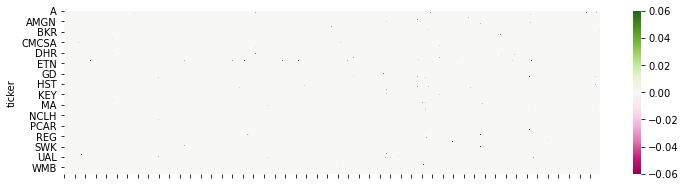

In [61]:
fig = plt.figure(figsize=(12,3))
_ = sns.heatmap(np.clip(buy_returns,-0.06,0.06).T,cmap="PiYG").set(xticklabels=[])


In [62]:
buy_returns

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS,MARKET
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.027543,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


buy:0.20011
mkt:0.06538


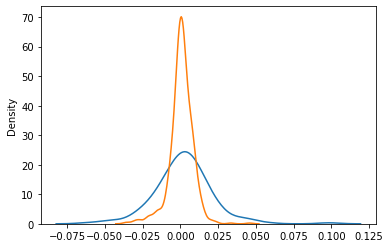

In [63]:
buy_returns[buy_returns==0]=np.nan
sns.kdeplot(np.nanmean(buy_returns,axis=1))
sns.kdeplot(returns["MARKET"].values)

print(f"buy:{100*np.nanmean(np.nanmean(buy_returns,axis=1)):.5f}")
print(f"mkt:{100*np.nanmean(returns['MARKET'].values):.5f}")

In [64]:
1.01**250

12.032155768297464

In [ ]:

start_trading = "2010-01-5"



returns = ComputeSuite.pct_return(all_data.loc[:,:,start_trading:])
returns.index = all_data.loc[:,:,start_trading:].ticker
returns.columns = np.array(all_data.loc[:,:,start_trading:]["eff_date"])


thred =-0.03
selected_return = []


state_previous_selected = False*np.ones(returns.values.shape[0])
skip = 0
for t in range(skip,returns.values.shape[1]-2)[::2]:

    return_t = returns.values[:,t]
    return_t_next = returns.values[:,t+1]
    signal = return_t<thred
    
    return_t[~signal] = None
    return_t_next[~signal] = None
    selected_return.append(return_t)
    selected_return.append(return_t_next)

    
    
selected_return  = np.array(selected_return).T  
model_return =  pd.DataFrame(selected_return[:,1:][:,::2])  

In [ ]:

start_trading = "2010-01-5"



res= []
for i in range(30):
    selected_return = []
    state_previous_selected = False*np.ones(returns.values.shape[0])
    skip = i
    for t in range(skip,returns.values.shape[1]-2)[::2]:

        return_t = returns.values[:,t]
        return_t_next = returns.values[:,t+1]
        signal = return_t<thred

        return_t[~signal] = None
        return_t_next[~signal] = None
        selected_return.append(return_t)
        selected_return.append(return_t_next)



    selected_return  = np.array(selected_return).T  
    model_return =  pd.DataFrame(selected_return[:,1:][:,::2])  
    res.append(model_return.mean(axis=0).mean())

In [ ]:
res

In [ ]:
model_return.mean(axis=1).mean()

In [ ]:
0.020768991037418447

In [ ]:
np.std(returns.values.ravel()[returns.values.ravel()>-99])

In [ ]:
np.std(rt)

In [ ]:
rt = model_return.mean(axis=1)

In [ ]:
sns.distplot(ct)

In [ ]:
sns.distplot(rt[ct>40])
sns.distplot(rt[ct<25],color="g")

In [ ]:
### old code below